# SIMPLE KRIGING IN PYTHON - 1D Application

*_Acknowledgement:_*

*This Notebook has been developed based on a blogpost by Connor Johnson,
http://connor-johnson.com/2014/03/20/simple-kriging-in-python/.*

In this post I will work through an example of Simple Kriging. Kriging is a set of techniques for interpolation. It differs from other interpolation techniques in that it sacrifices smoothness for the integrity of sampled points. Most interpolation techniques will over or undershoot the value of the function at sampled locations, but kriging honors those measurements and keeps them fixed. In future posts I would like to cover other types of kriging, other semivariaogram models, and colocated co-kriging. Until then, I’m keeping relatively up to date code at my GitHub project, geostatsmodels. (https://github.com/cjohnson318/geostatsmodels)

In [1]:
from pylab import *
import numpy as np
from pandas import DataFrame, Series
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [16 / 1.5, 10 / 1.5]   # inch / cm = 2.54
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
# plt.rcParams['savefig.frameon'] = False

In [2]:
import pandas as pd
df_Qts = pd.read_csv('5297Q_2010-14.txt',
                usecols =["DATUM","MESSWERT_NUM"] ,
                index_col=0, 
                parse_dates=True, 
                infer_datetime_format=True,
                dayfirst=True,
                decimal='.',
                sep=",")

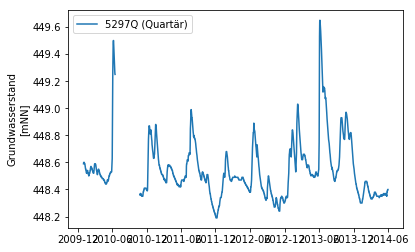

In [3]:
#plt.plot(df_5297T, label=u"5297T (Tertiär)")
plt.plot(df_Qts, label=u"5297Q (Quartär)")
plt.ylabel(u"Grundwasserstand\n[mNN]")
plt.legend()

In [4]:
#transform date to float and give differnce in days
import pandas as pd
import numpy as np

X = np.array(df_Qts.index.values - df_Qts.index.values.min(), dtype=(float)) / (1e9 * 60 * 60 * 24)

df_Qts = df_Qts.assign(X =X [:])
#df_QtsX= pd.write_csv('5297QX_2010-11.txt')({'DATUM' :df_Qts.index.values , 'MESSWERT_NUM' : df_Qts })

df_Qts["Y"] = 0.
P = np.array( df_Qts.dropna()[['X','Y','MESSWERT_NUM']] )
P



array([[0.0000e+00, 0.0000e+00, 4.4859e+02],
       [1.0000e+00, 0.0000e+00, 4.4860e+02],
       [2.0000e+00, 0.0000e+00, 4.4860e+02],
       ...,
       [1.6100e+03, 0.0000e+00, 4.4839e+02],
       [1.6110e+03, 0.0000e+00, 4.4840e+02],
       [1.6120e+03, 0.0000e+00, 4.4840e+02]])

## The Semivariogram

The semivariogram encodes data about spatial variance over the region at a given distance or lag. We generally expect data points that are close together spatially to share other characteristics, and we expect points that are separated by greater distances to have lesser correlation. The semivariogram allows us to model the similarity points in a field as a function of distance. The semivariogram is given by,

$$\begin{equation*} \hat{\gamma}(h) = \dfrac{1}{2N(h)} \displaystyle \sum_{N(h)} ( z_{i} - z_{j} )^{2} \end{equation*}$$ (Equation 1)

Here, h is distance specified by the user, and z_{i} and z_{j} are two points that are separated spatially by h. The N(h) term is the number of points we have that are separated by the distance h. The semivariogram then is the sum of squared differences between values separated by a distance h. As an aside, contrast this with the formulation for variance,

$$\begin{equation*} s = \dfrac{1}{N-1} \displaystyle \sum_{k=1}^{N} (z_{k} - \hat{\mu} )^{2} \end{equation*}$$ (Equation 2)

Here, $N$ is the number of data points, $\hat{\mu}$ is the sample mean, and $z_{k}$ is a data point. For sample variance, we are taking the squared difference between data points and the mean, and in the semivariogram we are taking the squared difference between data points separated by distance h. We can write some functions to calculate the semivariogram at one lag, and then at multiple lags as follows.

In [5]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )  # sample difference
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

The C() function is the covariance function, and will be used later. Let us now calculate and plot the semivariogram,

C:\Users\jomz\AppData\Local\conda\conda\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


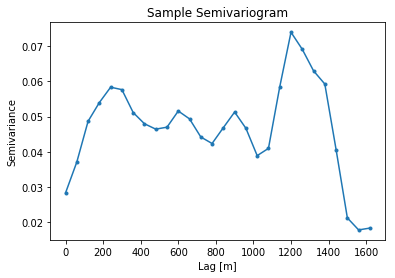

In [6]:

# bandwidth, plus or minus bw meters
bw = 60
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0, 2000, bw)
sv = SV( P, hs, bw )
plot( sv[0], sv[1], '.-' )
xlabel('Lag [m]')
ylabel('Semivariance')
title('Sample Semivariogram') ;
savefig('sample_semivariogram.png',fmt='png',dpi=200)


Modeling
Now that we’ve calculated the semivariogram, we will need to fit a model to the data. There are three popular models, the spherical, exponential, and the Gaussian. Here, we’ll implement the spherical model. First, we will present a function named opt() for determining the optimal value a for the spherical model.

In [7]:
def opt( fct, x, y, C0, parameterRange=None, meshSize=1000 ):
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]

The opt() function finds the optimal parameter for fitting a spherical model to the semivariogram data. The spherical model is given by the function spherical(). On the last line we see that spherical() returns itself in a map() function, which seems odd. The idea is that the input h can be a single float value, or list or NumPy array of floats. If h is a single value, then line 9 is called. If h is a list or an array (an iterable) then line 17 is called, which applies line 9 to each value of h.

In [8]:
def gaussian( h, a, C0, Cn=0 ):
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return Cn+(C0-Cn) * (1 - exp(-3*h**2/a**2))
        
    # if h is an iterable
    else:
        # calcualte the gaussian function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        return map( gaussian, h, a, C0, Cn )


In [9]:
def exponential( h, a, C0, Cn=0 ):
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        
        # calculate the exponential function
        return Cn+(C0-Cn) * (1 - exp(-3*h/a))
        
    # if h is an iterable
    else:
        # calcualte the exponential function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        return map( exponential, h, a, C0, Cn )

In [10]:
def spherical( h, a, C0, Cn=0 ):
    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return Cn+(C0-Cn)*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones( h.size ) * Cn
        return map( spherical, h, a, C0, Cn )

In [11]:
def hole (h, a, C0, Cn=0):
    
    if type(h) == np.float64:
        # calculate the spherical function
        return C0*(1-(1-h/a) * exp(-h/a) )

    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        return map( hole, h, a, C0, Cn )

In [12]:
def hole_N (h, C0, a, Cn=0):
    #from Triki et al. p.1600 (Dowdall et al. 2003)
    if type(h) == np.float64:
        # calculate the hole function
        if h == 0: 
            return Cn
        else:
            return Cn+(C0-Cn)*( 1-(sin(h/a ))/(h/a) )
    # if h is an iterable
    else:
        # calcualte the hole function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        return map( hole_N, h, a, C0, Cn )

Next, cvmodel() fits a model to the semivariogram data and returns a covariance method named covfct().

In [13]:
def cvmodel( P, model, hs, bw, Cn = None, svrange=None):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    if Cn is None:
        Cn = N(P, hs, bw)
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    # calculate the optimal parameters
    if svrange is None:
        svrange = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a=svrange: C0 - model( h, a, C0, Cn=Cn )
    return covfct

At this point we’ll plot our model and see if it represents our data well.

C:\Users\jomz\AppData\Local\conda\conda\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


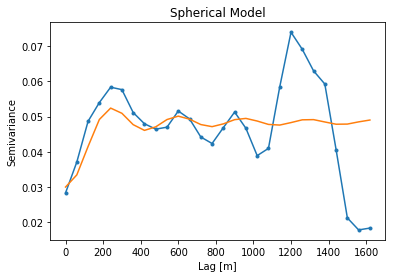

In [14]:
varmodel = hole_N  

sp = cvmodel( P, model=varmodel, hs=np.arange(0,2000,100), bw=bw, Cn=0.03,svrange = 55  )
C0 = C( P, hs[0], bw )
plot( sv[0], sv[1], '.-' )
plot( sv[0], C0 - sp( sv[0] ) ) ;
title('Spherical Model')
ylabel('Semivariance')
xlabel('Lag [m]')
savefig('semivariogram_model.png',fmt='png',dpi=200)


## Simple Kriging


Now that we have a model for the semivariogram, we can write a function to perform the kriging. The fundamental relationship is a matrix equation,

$$\begin{equation*} K \lambda = k \Rightarrow \lambda = K^{-1} k \end{equation*} $$ 

Here, $K$ is a matrix of covariances calculated using the spherical model, $\lambda$ is a vector of simple kriging weights, and $k$ is the vector of covariances between the data points and an unsampled point. Our kriging function takes the data set $P$, the model, the distances hs, the bandwidth bw, the coordinates of the unsampled point u, and the number of surrounding points N to use in the calculation.

## Calculation for all Points

Here, we’ll calculate the kriging estimate at a number of unsampled points.

In [15]:
def krige( P, covfct, u, N ):
    '''
    Input  (P)     ndarray, data
           (covfct) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''

    assert N < len(P) + 1, "Number of Neighbors greater than number of data points"

    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return (float( estimation ), k, K, weights)

# Plotting the Estimator - 1D

In [18]:
# sampling intervall:
X0, X1 = 0., 1800.

# number of samples
n = 1800
dx = (X1-X0)/n
print("Sampling resolution: {:.2f} days".format(dx))

# number of neighbors:
nn = 200


Sampling resolution: 1.00 days


In [19]:
# create a progress bar
from ipywidgets import FloatProgress
from IPython.display import display
wdgt = FloatProgress(min=0, max=n, description="Running Kriging ... ")
display(wdgt)

Z = np.zeros(n)
V = np.zeros(n)
for i in range(n):
    wdgt.value += 1
    h, k, K, weights = krige( P, sp, (dx*i, 0), nn )
    Z[i] = h
    v = C0 - np.dot(k.T, weights)
    V[i] = max (v, 0)

FloatProgress(value=0.0, description=u'Running Kriging ... ', max=1800.0)

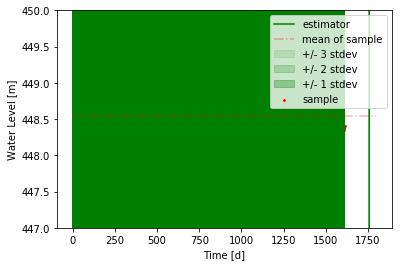

In [20]:
plt.fill_between([i*dx for i in range(n)], Z-3*np.sqrt(V), Z+3*np.sqrt(V), color='green', alpha=0.1, label="+/- 3 stdev")
plt.fill_between([i*dx for i in range(n)], Z-2*np.sqrt(V), Z+2*np.sqrt(V), color='green', alpha=0.2, label="+/- 2 stdev")
plt.fill_between([i*dx for i in range(n)], Z-1*np.sqrt(V), Z+1*np.sqrt(V), color='green', alpha=0.3, label="+/- 1 stdev")
plt.plot([i*dx for i in range(n)], Z, "g-", label="estimator")
plt.scatter(df_Qts.X, df_Qts.MESSWERT_NUM, c="r", label="sample", s=3)
plt.plot((X0, X1),(df_Qts.MESSWERT_NUM.mean(),df_Qts.MESSWERT_NUM.mean()), "r-.", label="mean of sample", alpha=0.3,)
plt.legend(loc='upper right')
ylabel('Water Level [m]')
xlabel('Time [d]')

x1,x2,y1,y2 = plt.axis()

plt.axis((x1,x2,447, 450))
#plt.savefig("result_gaussian_model_.png")
plt.show()

### Questions:
+ search for neighbour strategy: instead of fixed number, use on left, one right (if applicable)?
+ unsymetric (up down behavior)?


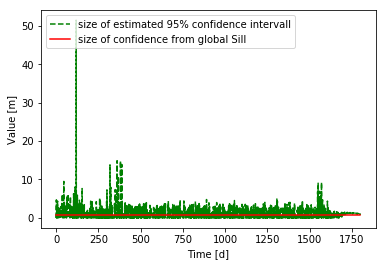

In [21]:
plt.plot([i*dx for i in range(n)], 2*1.96*np.sqrt(V), "g--", label="size of estimated 95% confidence intervall")
plt.plot((X0, X1),(2*1.96*np.sqrt(C0), 2*1.96*np.sqrt(C0)), "r-", label="size of confidence from global Sill")
plt.legend(loc='upper left')
#plt.scatter(df_Qts.X, (df_Qts.MESSWERT_NUM-448)*30, c="r", label="sample", s=3)

#plt.scatter(df_Qts.X, np.ones_like(df_Qts.X), c="r", label="sample", s=3)

ylabel('Value [m]')
xlabel('Time [d]')
#plt.axis((-1,10,0, 25))
_ = plt.show()

In [ ]:
%matplotlib inline

In [ ]:
sqrt(0.02)